# Analyse du jeu de données TAWOS

> 13 référentiels open source ont été extrait : Apache, Appcelerator, Atlassian, DNNSoftware, Hyperledger, Lsstcorp, Lyrasis DuraSpace, MongoDB, Moodle, MuleSoft, Spring, Sonatype et Talendforge.

La plupart de ces référentiels ont été utilisés dans le cadre de travaux antérieurs et **tous utilisent Jira comme plateforme de gestion des problèmes**,
ce qui garantit l'uniformité de la structure et la disponibilité des informations. Dans chacun de ces référentiels, des projets ont été sélectionnés de manière à ce qu'ils adoptent un développement itératif et une **gestion des problèmes**.

In [8]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
load_dotenv()

# Informations de la base de données SQL contenant le jeux de données TAWOS
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
database = os.getenv("DB_DATABASE")

## Connexion à la base de données SQL (TAWOS)

In [3]:
engine = create_engine(
    f"mariadb+mysqldb://{user}:{password}@{host}:{port}/{database}"
)

issue = pd.read_sql_table("Issue", engine) # "ID", "Title", "Description", "Status", "Resolution", "Last_Updated"
comment = pd.read_sql_table("Comment", engine) # "Issue_ID", "Comment"

## Analyse des Issues

In [4]:
print(f"Nombre d'issues : {issue.shape[0]}")
print(f"Nombre de features dans la table 'Issue' : {issue.shape[1]}")

Nombre d'issues : 458232
Nombre de features dans la table 'Issue' : 30


### Type des issues

In [5]:
issue.dtypes

ID                                               int64
Jira_ID                                          int64
Issue_Key                                       object
URL                                             object
Title                                           object
Description                                     object
Description_Text                                object
Description_Code                                object
Type                                            object
Priority                                        object
Status                                          object
Resolution                                      object
Creation_Date                           datetime64[ns]
Estimation_Date                         datetime64[ns]
Resolution_Date                         datetime64[ns]
Last_Updated                            datetime64[ns]
Story_Point                                    float64
Timespent                                      float64
In_Progres

In [6]:
issue_reduce = issue[["ID", "Title", "Description", "Type", "Status", "Resolution", "Last_Updated"]]
issue_clean = issue_reduce.dropna()
print(issue_clean.shape)
issue_clean.head()

(380734, 7)


,ID,Title,Description,Type,Status,Resolution,Last_Updated
3,68,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...",Story,Done,Complete,2017-03-22 18:27:01
20,85,"""Unable to register the JMX bean MessageHistor...","""If I try to use <int:message-history/> when d...",Bug,Done,Complete,2016-12-23 14:49:45
21,86,"""Rabbit Bus: Expose ChannelCacheSize on Cachin...","""http://stackoverflow.com/questions/35563064/p...",Improvement,Done,Complete,2016-12-23 14:49:26
22,87,"""Update Spring Framework to 4.2.4""",,Improvement,Done,Complete,2016-02-23 18:19:10
23,88,"""Update Spring-AMQP to 3.6, RabbitMQ Client to...","""Update to amqp-client 3.6.0 and spring-amqp 1...",Improvement,Done,Complete,2016-02-23 18:18:33


In [7]:
type_values = issue_clean["Type"].value_counts()
type_values

Type
Bug                              191565
Suggestion                        67586
Improvement                       31837
Story                             26540
Task                              24965
Sub-task                          13388
New Feature                       11395
Epic                               3062
Enhancement Request                3055
Support Request                    2362
Build Failure                      1701
Question                           1352
Technical task                      887
Documentation                       526
Test Task                           286
Problem Ticket                      103
Milestone                            34
Wish                                 28
Technical Debt                       25
Incident                             18
Test                                  9
Investigation                         5
Release                               4
Public Security Vulnerability         1
Name: count, dtype: int64

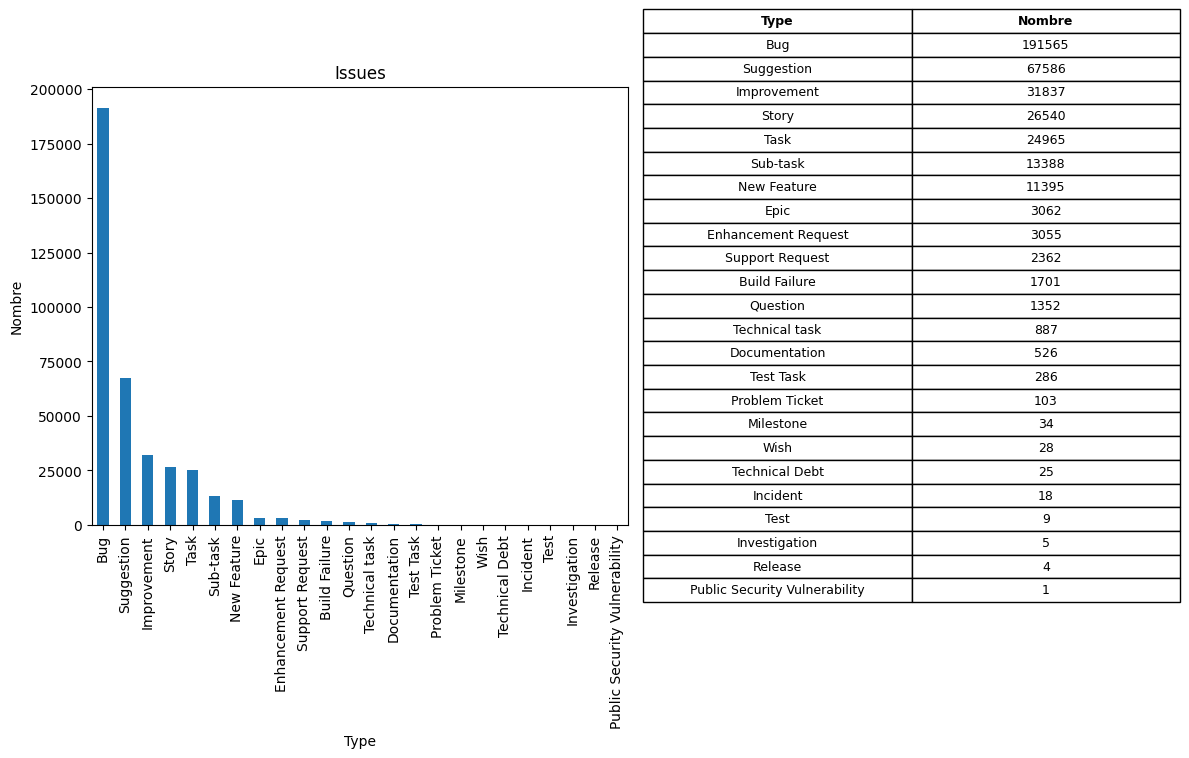

In [22]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Premier sous-graphe : le graphique à barres
ax1 = fig.add_subplot(gs[0])
type_values.plot(kind='bar', ax=ax1)
ax1.set_title("Issues")
ax1.set_ylabel('Nombre')

# Deuxième sous-graphe : le tableau des valeurs
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Supprimer les axes du tableau
table = ax2.table(cellText=type_values.reset_index().values, 
                  colLabels=['Type', 'Nombre'],
                  cellLoc='center', 
                  loc='center')

# Appliquer du gras uniquement sur les cellules de l'en-tête
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Si la ligne est l'en-tête (i == 0)
        cell.set_text_props(weight='bold')  # Appliquer du gras

# Ajuster la taille du tableau
table.scale(1, 2)

plt.tight_layout()
plt.savefig("types_issues.png")
plt.show()

Les types d'issues que l'on va conserver sont :
- Bug
- Support Request
- Question
- Problem Ticket                      
- Incident                             

In [23]:
issue_clean_type = issue_clean[(issue_clean["Type"] == "Bug") | (issue_clean["Type"] == "Support Request") | (issue_clean["Type"] == "Question") | (issue_clean["Type"] == "Problem Ticket") | (issue_clean["Type"] == "Incident")]
issue_clean_type.shape

(195400, 7)

### Status des issues

In [24]:
issue_clean_type["Status"].unique()

array(['Done', 'Resolved', 'Closed', 'Gathering Impact', 'Complete',
       'Invalid', "Won't Fix", 'Planned Development', 'Open',
       'Pull Request Submitted', 'In Review', 'Reopened', 'In Progress',
       'Automation'], dtype=object)

In [25]:
status_values = issue_clean_type["Status"].value_counts()
status_values

Status
Closed                    185212
Resolved                    5765
Done                        2394
Complete                    1463
Won't Fix                    179
Invalid                      173
Open                         160
Planned Development           41
Reopened                       5
Pull Request Submitted         3
In Review                      2
Gathering Impact               1
In Progress                    1
Automation                     1
Name: count, dtype: int64

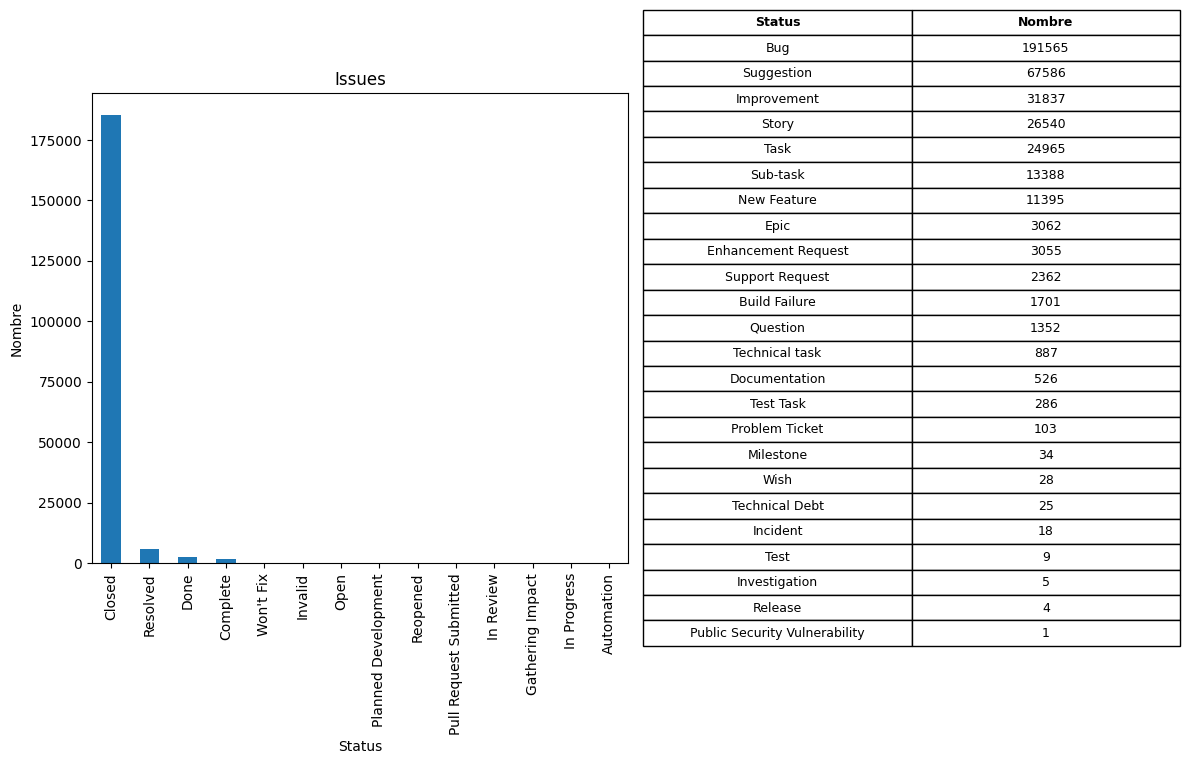

In [31]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Premier sous-graphe : le graphique à barres
ax1 = fig.add_subplot(gs[0])
status_values.plot(kind='bar', ax=ax1)
ax1.set_title("Issues")
ax1.set_ylabel('Nombre')

# Deuxième sous-graphe : le tableau des valeurs
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Supprimer les axes du tableau
table = ax2.table(cellText=type_values.reset_index().values, 
                  colLabels=['Status', 'Nombre'],
                  cellLoc='center', 
                  loc='center')

# Appliquer du gras uniquement sur les cellules de l'en-tête
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Si la ligne est l'en-tête (i == 0)
        cell.set_text_props(weight='bold')  # Appliquer du gras

# Ajuster la taille du tableau
table.scale(1, 2)

plt.tight_layout()
plt.savefig("status_issues.png")
plt.show()

On ne garde que les 4 premiers status :
- Closed
- Resolved
- Done
- Complete

In [28]:
issue_clean_type_status = issue_clean_type[(issue_clean_type["Status"] == "Closed") | (issue_clean_type["Status"] == "Done") | (issue_clean_type["Status"] == "Resolved") | (issue_clean_type["Status"] == "Complete")]
print(issue_clean_type_status.shape)
issue_clean_type_status.head()

(194834, 7)


,ID,Title,Description,Type,Status,Resolution,Last_Updated
20,85,"""Unable to register the JMX bean MessageHistor...","""If I try to use <int:message-history/> when d...",Bug,Done,Complete,2016-12-23 14:49:45
25,90,"""Update to Spring Integration 4.2.5 When Avail...","""See INT-3956""",Bug,Done,Complete,2016-02-21 02:28:25
27,92,"""[Flo] Stream creation/definitions doesn't sho...",""" As a Flo for Spring XD user, I would like to...",Bug,Done,Complete,2016-02-21 02:28:36
28,93,"""Kafka message bus maxWait property is not set...","""The maxWait property from server.yml in the m...",Bug,Done,Complete,2016-02-21 02:28:22
29,94,"""Incorrect refresh period for groovy scripts""","""All modules that allow groovy implementations...",Bug,Done,Complete,2016-02-12 22:08:54


### Résolution des issues

In [29]:
issue_clean_type_status["Resolution"].unique()

array(['Complete', 'Invalid', 'Works as Designed', 'Deferred',
       'Cannot Reproduce', "Won't Fix", 'Duplicate', 'Fixed',
       'Incomplete', 'Done', 'Not A Bug', 'Automatically Closed',
       'Parked', 'Out of scope', "Won't Do", 'Not A Problem', 'Resolved',
       'Information Provided', 'Later', 'Workaround', 'Works for Me',
       'Pending Closed', 'Implemented', 'Abandoned', 'Feedback Received',
       'Not Our Bug', 'Needs more info', 'Hold', 'Tracked Elsewhere',
       'Handled by Support', 'Obsolete', 'Not a bug', 'Answered',
       'Timed out', 'Resolved Locally', 'Unsolved Mysteries',
       'Incorrectly Filed', 'Support Request', 'Deployed',
       'Invalid: Works as Expected', 'Invalid: Environment Issue',
       'Invalid: Test Error', 'Invalid: Not Supported', 'Ready for Test',
       'Ready for Release', 'Community Answered', 'Declined', 'Gone away',
       'Inactive', 'Completed', "Won't Fix or Usage Issue", 'Rejected',
       'Unresolved'], dtype=object)

In [30]:
resolution_values = issue_clean_type_status["Resolution"].value_counts()
resolution_values

Resolution
Fixed                         93068
Duplicate                     19099
Won't Fix                     17021
Cannot Reproduce              10170
Done                           8423
Timed out                      8284
Not a bug                      5782
Obsolete                       5092
Invalid                        4693
Support Request                4087
Complete                       3468
Works as Designed              2278
Answered                       2187
Incomplete                     1517
Gone away                      1390
Handled by Support             1251
Tracked Elsewhere              1210
Won't Fix or Usage Issue       1085
Won't Do                        822
Resolved Locally                582
Deferred                        517
Needs more info                 381
Not Our Bug                     351
Not A Bug                       309
Completed                       251
Invalid: Works as Expected      210
Hold                            188
Inactive         

/tmp/ipykernel_5478/2581088846.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


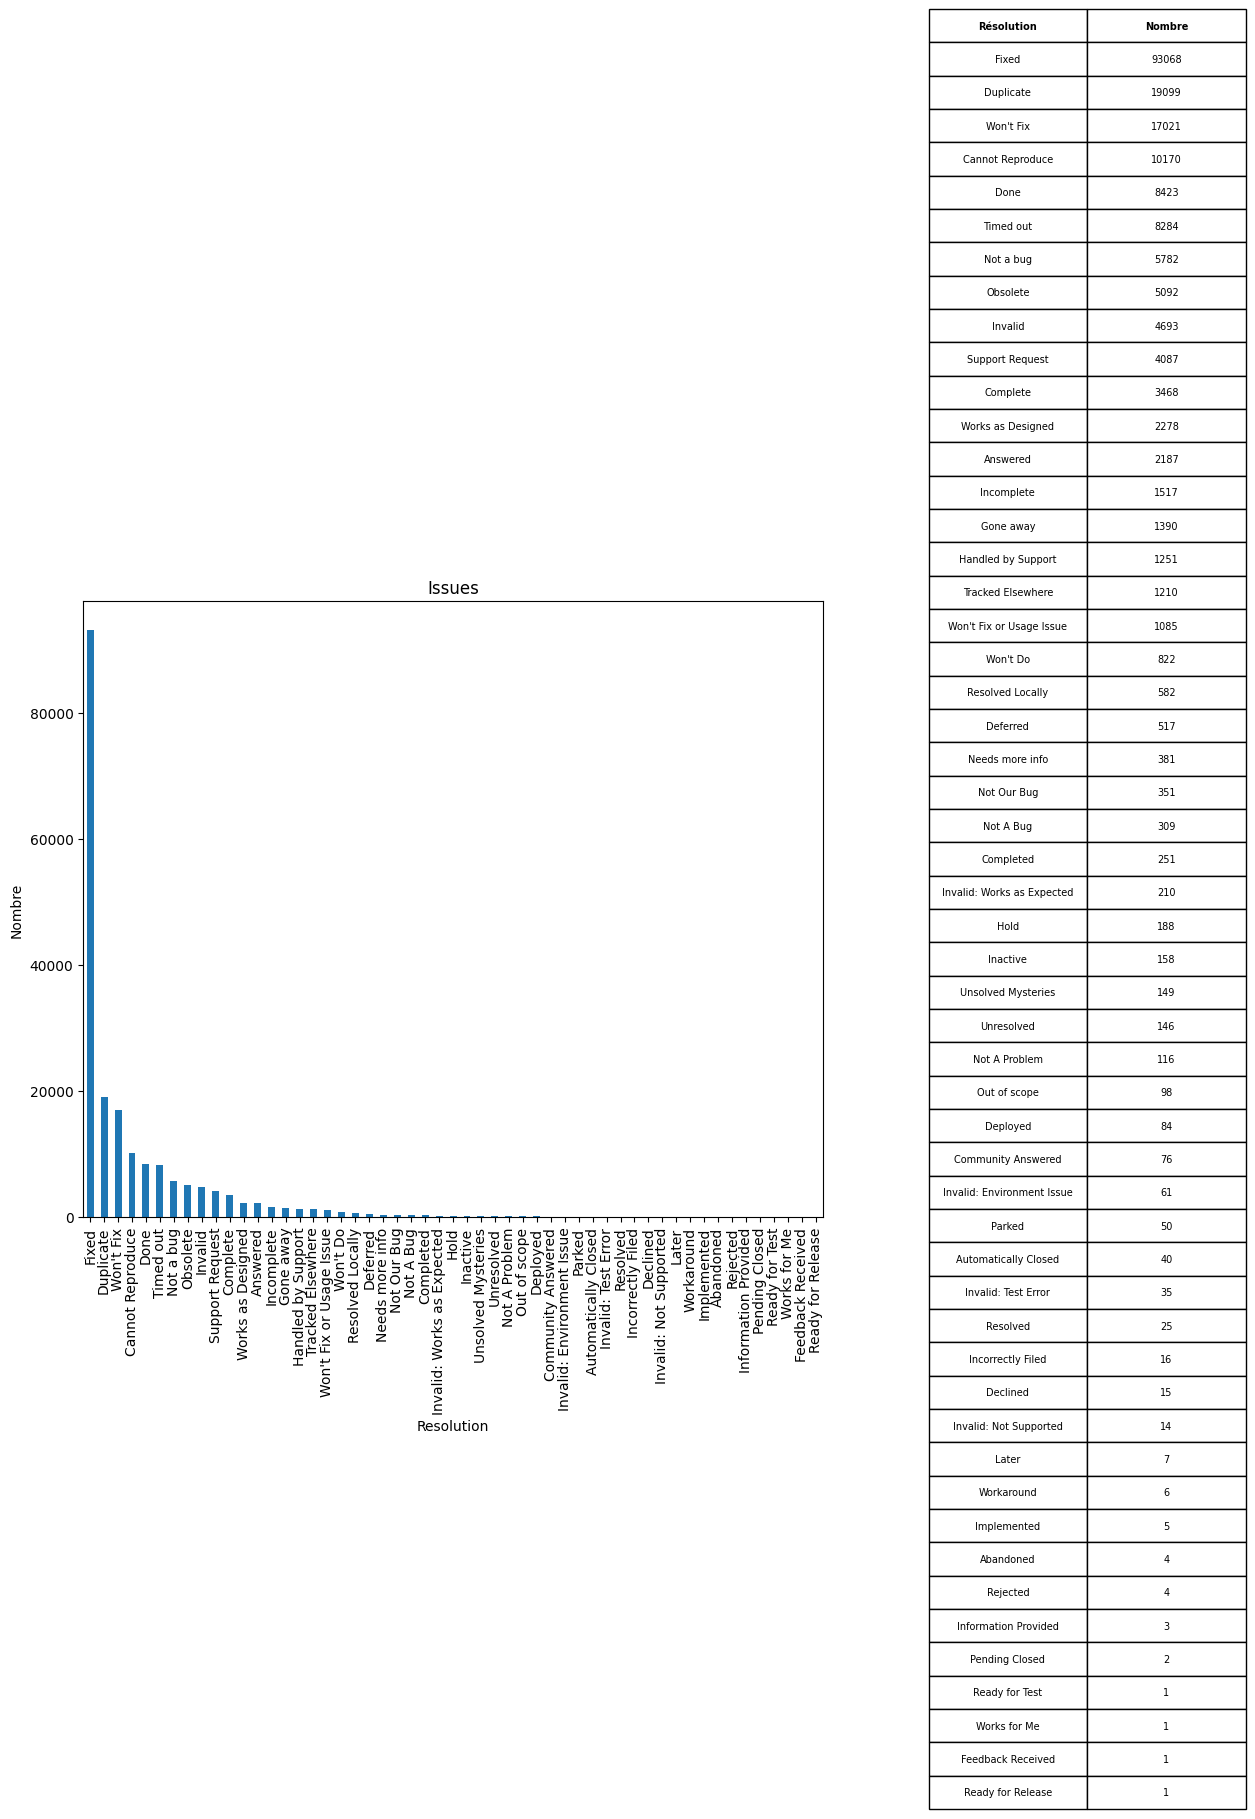

In [34]:
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(1, 2, width_ratios=[0.7, 0.3])

# Premier sous-graphe : le graphique à barres
ax1 = fig.add_subplot(gs[0])
resolution_values.plot(kind='bar', ax=ax1)
ax1.set_title("Issues")
ax1.set_ylabel('Nombre')

# Deuxième sous-graphe : le tableau des valeurs
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Supprimer les axes du tableau
table = ax2.table(cellText=resolution_values.reset_index().values, 
                  colLabels=['Résolution', 'Nombre'],
                  cellLoc='center', 
                  loc='center')

# Appliquer du gras uniquement sur les cellules de l'en-tête
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Si la ligne est l'en-tête (i == 0)
        cell.set_text_props(weight='bold')  # Appliquer du gras

# Ajuster la taille du tableau
table.scale(1, 2)

plt.tight_layout()
plt.savefig("resolution_issues.png")
plt.show()

Les types de résolution que l'on va traîter sont : 
- Fixed
- Done
- Support Request                
- Complete                       
- Answered                       
- Completed                       
- Community Answered               
- Resolved                         

In [35]:
issue_clean_type_status_resolution = issue_clean_type_status[(issue_clean_type_status["Resolution"] == "Fixed") | (issue_clean_type_status["Resolution"] == "Done") | (issue_clean_type_status["Resolution"] == "Support Request") | (issue_clean_type_status["Resolution"] == "Complete") | (issue_clean_type_status["Resolution"] == "Answered") | (issue_clean_type_status["Resolution"] == "Completed") | (issue_clean_type_status["Resolution"] == "Community Answered") | (issue_clean_type_status["Resolution"] == "Resolved")]
print(issue_clean_type_status_resolution.shape)
issue_clean_type_status_resolution.head()

(111585, 7)


,ID,Title,Description,Type,Status,Resolution,Last_Updated
20,85,"""Unable to register the JMX bean MessageHistor...","""If I try to use <int:message-history/> when d...",Bug,Done,Complete,2016-12-23 14:49:45
25,90,"""Update to Spring Integration 4.2.5 When Avail...","""See INT-3956""",Bug,Done,Complete,2016-02-21 02:28:25
27,92,"""[Flo] Stream creation/definitions doesn't sho...",""" As a Flo for Spring XD user, I would like to...",Bug,Done,Complete,2016-02-21 02:28:36
28,93,"""Kafka message bus maxWait property is not set...","""The maxWait property from server.yml in the m...",Bug,Done,Complete,2016-02-21 02:28:22
29,94,"""Incorrect refresh period for groovy scripts""","""All modules that allow groovy implementations...",Bug,Done,Complete,2016-02-12 22:08:54


## Analyse des commentaires

In [36]:
print(f"Nombre de commentaires : {comment.shape[0]}")
print(f"Nombre de features dans la table 'Comment' : {comment.shape[1]}")

Nombre de commentaires : 1518327
Nombre de features dans la table 'Comment' : 7


In [37]:
comment.dtypes

ID                        int64
Comment                  object
Comment_Text             object
Comment_Code             object
Creation_Date    datetime64[ns]
Author_ID               float64
Issue_ID                  int64
dtype: object

In [38]:
comment_reduce = comment[["Issue_ID", "Comment"]]
comment_clean = comment_reduce.dropna()
print(comment_clean.shape)
comment_clean.head()

(1518327, 2)


,Issue_ID,Comment
0,68,See https://github.com/spring-projects/spring-...
1,73,Please refer to the attached document. We will...
2,73,Thanks Sabby. I tried structuring the AD to th...
3,73,Notice the following piece of code (https://gi...
4,75,Hi [~<USER>: \n\nCan you confirm you have the ...


In [47]:
# Regrouper tous les commentaires d'une Issue_ID dans un seul enregistrement
comment_clean_grouped = comment_clean.groupby('Issue_ID')['Comment'].agg(lambda x: ', '.join(x)).reset_index()
print(comment_clean_grouped.shape)
comment_clean_grouped.head()

(363351, 2)


,Issue_ID,Comment
0,68,See https://github.com/spring-projects/spring-...
1,73,Please refer to the attached document. We will...
2,75,Hi [~<USER>: \n\nCan you confirm you have the ...
3,76,Can you explain further?\n\nThere is only one ...
4,77,"After I changed to another VM, which is CDH 5...."


In [46]:
comment_clean_grouped[comment_clean_grouped['Issue_ID'] == 73].values

array([[73,
        'Please refer to the attached document. We will eventually get this added to the reference guide. Hope this helps. , Thanks Sabby. I tried structuring the AD to the document, with two OU of users and guides. But windows AD base users\' DN on "CN=User1, OU=Users, OU=Company, DN=COMPANY, DC=SG"\n\nCurrently it is unable to get the ROLE from the attribute CN in AD, because it is unable to search for the user in the group. My suspicion is because the SpringXD search based on "uid=User1,OU=Users,OU=Company, DN=COMPANY, DC=SG" rather than "CN=User1, OU=Users, OU=Company, DN=COMPANY, DC=SG"\n\nCan you assist with that?\n\n\n, Notice the following piece of code (https://github.com/spring-projects/spring-xd/blob/115487070e9196a4bb8bfd9b6fe8b85494ac6cca/spring-xd-dirt/src/main/java/org/springframework/xd/dirt/server/security/LdapAuthenticationConfiguration.java#L171)\n{code:java}\nldapConfigurer.ldapAuthoritiesPopulator(new LdapAuthoritiesPopulator() {\n    @Override\n    pub

## Issue + Commentaires

In [48]:
issue_comment_merge = issue_clean_type_status_resolution.merge(comment_clean_grouped, left_on='ID', right_on='Issue_ID')
del issue_comment_merge["Issue_ID"]
print(issue_comment_merge.shape)
issue_comment_merge.head()

(99094, 8)


,ID,Title,Description,Type,Status,Resolution,Last_Updated,Comment
0,85,"""Unable to register the JMX bean MessageHistor...","""If I try to use <int:message-history/> when d...",Bug,Done,Complete,2016-12-23 14:49:45,This is a bug in the {{ModuleObjectNamingStrat...
1,92,"""[Flo] Stream creation/definitions doesn't sho...",""" As a Flo for Spring XD user, I would like to...",Bug,Done,Complete,2016-02-21 02:28:36,Hi [~<USER>: Latest Chrome update requires upg...
2,93,"""Kafka message bus maxWait property is not set...","""The maxWait property from server.yml in the m...",Bug,Done,Complete,2016-02-21 02:28:22,The property is not set up in the kafka-bus.xm...
3,96,"""REST - Do not redirect after logout""","""In the following PR we removed the *RestLogou...",Bug,Done,Complete,2016-02-03 19:55:37,Merged as https://github.com/spring-projects/s...
4,103,"""NPE in spring-integration when using kafka as...","""as stated in https://jira.spring.io/browse/IN...",Bug,Done,Complete,2016-02-28 19:36:42,Hi [~<USER>: This is already addressed in 1.3....


In [51]:
issue_comment_merge["Title"] = issue_comment_merge["Title"].astype('string')
issue_comment_merge["Description"] = issue_comment_merge["Description"].astype('string')
issue_comment_merge["Type"] = issue_comment_merge["Type"].astype('string')
issue_comment_merge["Status"] = issue_comment_merge["Status"].astype('string')
issue_comment_merge["Resolution"] = issue_comment_merge["Resolution"].astype('string')
issue_comment_merge["Comment"] = issue_comment_merge["Comment"].astype('string')
issue_comment_merge['Comment'] = issue_comment_merge['Comment'].apply(lambda x: f'"{x}"')
issue_comment_merge.dtypes

ID                       int64
Title           string[python]
Description     string[python]
Type            string[python]
Status          string[python]
Resolution      string[python]
Last_Updated    datetime64[ns]
Comment                 object
dtype: object

In [52]:
issue_comment_merge.head()

,ID,Title,Description,Type,Status,Resolution,Last_Updated,Comment
0,85,"""Unable to register the JMX bean MessageHistor...","""If I try to use <int:message-history/> when d...",Bug,Done,Complete,2016-12-23 14:49:45,"""""This is a bug in the {{ModuleObjectNamingStr..."
1,92,"""[Flo] Stream creation/definitions doesn't sho...",""" As a Flo for Spring XD user, I would like to...",Bug,Done,Complete,2016-02-21 02:28:36,"""""Hi [~<USER>: Latest Chrome update requires u..."
2,93,"""Kafka message bus maxWait property is not set...","""The maxWait property from server.yml in the m...",Bug,Done,Complete,2016-02-21 02:28:22,"""""The property is not set up in the kafka-bus...."
3,96,"""REST - Do not redirect after logout""","""In the following PR we removed the *RestLogou...",Bug,Done,Complete,2016-02-03 19:55:37,"""""Merged as https://github.com/spring-projects..."
4,103,"""NPE in spring-integration when using kafka as...","""as stated in https://jira.spring.io/browse/IN...",Bug,Done,Complete,2016-02-28 19:36:42,"""""Hi [~<USER>: This is already addressed in 1...."


In [54]:
issue_comment_merge.to_csv("jira_issues.csv", quoting=csv.QUOTE_MINIMAL, sep=";", escapechar="\\")

In [53]:
print(issue_comment_merge.iloc[0]["Comment"])

""This is a bug in the {{ModuleObjectNamingStrategy}} - it assumes the beanKey is already formatted to call {{ObjectNameManager.getInstance()}}.

The standard naming strategy catches this exception and reformats the key...

{code}
			catch (MalformedObjectNameException ex) {
				String domain = this.defaultDomain;
				if (domain == null) {
					domain = ClassUtils.getPackageName(managedClass);
				}
				Hashtable<String, String> properties = new Hashtable<String, String>();
				properties.put("type", ClassUtils.getShortName(managedClass));
				properties.put("name", beanKey);
				return ObjectNameManager.getInstance(domain, properties);
			}
{code}

The XD custom naming strategy should subclass {{MetadataNamingStrategy}} as is done for the default Spring Integration naming strategy.""
